In [2]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Bibliotecas dos Modelos Utilizados
from sklearn.linear_model import LogisticRegression  # Regressão Logística.
from sklearn.svm import SVC                          # Máquinas de Vetores de Suporte (SVM).
from sklearn.neighbors import KNeighborsClassifier   # K-Vizinhos Mais Próximos
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [4]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [5]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Manobrabilidade'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Manobrabilidade
0,1375.000000,1320.000000,1275.000000,1550.000000,2050.000000,570.000000,69.068493,95.743105,0.417540,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1437.352834,1301.084856,1257.383792,1526.436265,2065.013452,512.661006,68.164649,98.483069,0.417531,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1352.624255,1320.913741,1182.351714,1606.885444,2077.082448,566.917181,69.938385,103.583059,0.415100,0.505086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1307.150880,1511.199063,1282.562627,1611.635996,1982.262142,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1393.831096,1408.554269,1398.255323,1554.642728,1946.073774,497.782392,84.085097,125.785803,0.401552,0.503254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'SD_Dimensoes dos pneus',
    'ST_Curso Positivo de projeto',
    'ST_Curso Negativo de projeto',
    'ST_Dimensoes dos pneus',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'MT_Potência maxima do motor',
    'MT_Torque maximo do motor',
    'MT_Relacao total_max',
    'MT_Relacao total_min',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Tempo para atingir velocidade maxima em asfalto', 
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [7]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   DP_Entre-Eixo                                            752 non-null    float64
 1   DP_Bitola Dianteira                                      752 non-null    float64
 2   DP_Bitola Traseira                                       752 non-null    float64
 3   DP_Altura                                                752 non-null    float64
 4   DP_Comprimento                                           752 non-null    float64
 5   DP_Altura do CG com relacao ao chao                      210 non-null    float64
 6   MV_Eixo dianteiro                                        730 non-null    float64
 7   MV_Eixo Traseiro                                         730 non-null    float64
 8   DMV_Dianteira                

In [8]:
# Descrição de dados
df.describe()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,D_Inclinacao do pino mestre,D_Angulo de caster,CD_Raio mínimo de curva do protótipo,CD_Velocidade crítica para uma curva de raio de 10 m,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em terra batida,P_Manobrabilidade
count,752.000000,752.000000,752.000000,752.000000,752.000000,210.000000,730.000000,730.000000,730.000000,210.000000,...,165.000000,168.000000,79.000000,23.000000,33.000000,22.000000,20.000000,299.000000,233.000000,1000.000000
mean,1429.187935,1316.617366,1236.326356,1529.613013,1997.510367,520.386004,72.474990,103.671614,0.412051,0.507617,...,9.416956,13.128448,2.065575,51.307284,3.012496,3.643150,3.963698,49.927548,8.053036,3.000000
std,47.082116,81.981253,75.475135,237.369967,68.298826,93.491430,10.531986,11.898377,0.026909,0.048453,...,3.489285,3.247354,0.485423,25.703823,1.445604,3.518759,1.706537,4.708608,5.016449,1.414921
min,1300.000000,633.525807,779.185251,284.003108,1769.958834,186.412435,47.074351,78.901171,0.317764,0.170525,...,0.875795,5.523538,1.388713,27.080000,0.116048,0.701290,3.014028,35.933263,3.640437,1.000000
25%,1398.512029,1279.934599,1199.890201,1488.447799,1970.000000,483.773215,67.152586,95.325189,0.396118,0.491626,...,6.470929,11.006856,1.748839,28.065372,2.112095,1.245156,3.149093,47.384463,4.887420,2.000000
50%,1427.110999,1304.428280,1223.796112,1535.816459,2003.875417,515.483959,70.972704,104.663241,0.411081,0.500000,...,9.121771,13.707689,1.917743,41.865701,2.598651,1.485739,3.266039,50.752592,6.339804,3.000000
75%,1463.117627,1353.362300,1270.902095,1596.632963,2036.898595,556.200465,77.513636,109.819531,0.430674,0.514104,...,12.271597,15.914815,2.181378,68.666063,4.410000,6.430000,3.590000,53.141379,9.395803,4.000000
max,1581.999822,1596.088802,1490.000000,2366.353799,2151.967468,1022.114272,129.074739,154.486862,0.482281,0.650000,...,16.734271,19.804663,3.498281,99.658516,6.689736,13.587500,10.119773,60.657918,27.025616,5.000000


In [9]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.") 

'DP_Entre-Eixo' tem 0.
'DP_Bitola Dianteira' tem 0.
'DP_Bitola Traseira' tem 0.
'DP_Altura' tem 0.
'DP_Comprimento' tem 0.
'DP_Altura do CG com relacao ao chao' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'DMV_Lado Direito' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 17.
'PCG_Z' tem 0.
'SD_Cambagem estatica' tem 131.
'SD_Convergência estatica' tem 133.
'ST_Cambagem estatica' tem 122.
'ST_Convergência estatica' tem 114.
'D_Relacao' tem 0.
'D_Curso total da cremalheira' tem 0.
'D_Inclinacao do pino mestre' tem 0.
'D_Angulo de caster' tem 0.
'CD_Raio mínimo de curva do protótipo' tem 0.
'CD_Velocidade crítica para uma curva de raio de 10 m' tem 0.
'CD_Ganho de rolagem por aceleracao lateral' tem 0.
'CD_Ganho de arfagem em aceleracao longitudinal' tem 0.
'CD_Ganho de arfagem em desaceleracao longitudinal' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em terra batida' tem 0.
'P_Manobrabilidade' t

## Limpeza

In [10]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 850 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Entre-Eixo                                              248
DP_Bitola Dianteira                                        248
DP_Bitola Traseira                                         248
DP_Altura                                                  248
DP_Comprimento                                             248
DP_Altura do CG com relacao ao chao                        790
MV_Eixo dianteiro                                          270
MV_Eixo Traseiro                                           270
DMV_Dianteira                                              270
DMV_Lado Direito                                           790
PCG_X                                                      270
PCG_Y                                                       22
PCG_Z                                                      270
SD_Cambagem estatica                                       829
ST_Cambagem estatica                                       847
D_Relacao                                              

In [11]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Altura do CG com relacao ao chao',
    'DMV_Lado Direito',
    'SD_Cambagem estatica',
    'ST_Cambagem estatica',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [12]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([ 13,  23,  27,  35,  37,  38,  40,  41,  50,  54,
            ...
            975, 978, 979, 980, 983, 988, 991, 992, 994, 999],
           dtype='int64', length=248)
     DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0      1375.000000          1320.000000         1275.000000  1550.000000   
1      1437.352834          1301.084856         1257.383792  1526.436265   
2      1352.624255          1320.913741         1182.351714  1606.885444   
3      1307.150880          1511.199063         1282.562627  1611.635996   
4      1393.831096          1408.554269         1398.255323  1554.642728   
..             ...                  ...                 ...          ...   
993    1497.768383          1300.000000         1200.000000   691.051581   
995    1458.353300          1291.303150         1196.160187  1391.839336   
996    1500.000000          1297.592843         1210.496743  1464.867874   
997    1514.746926          1261.565233         1191.948088  

In [13]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Manobrabilidade'] = df['P_Manobrabilidade'].replace(mapeamento)

print(df['P_Manobrabilidade'])

0      0
1      0
2      0
3      0
4      0
      ..
993    4
995    4
996    4
997    4
998    4
Name: P_Manobrabilidade, Length: 752, dtype: int64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=False)

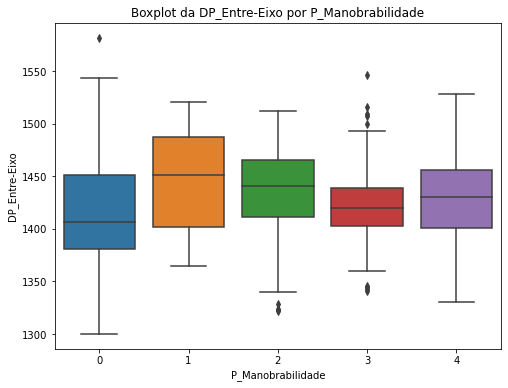

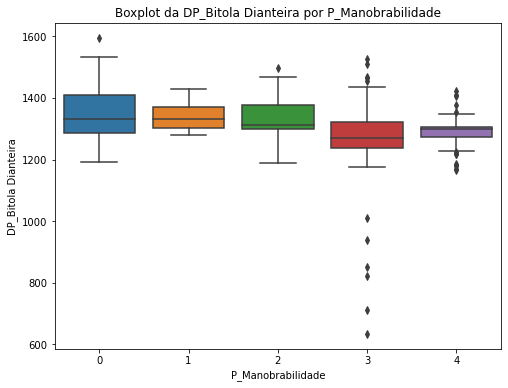

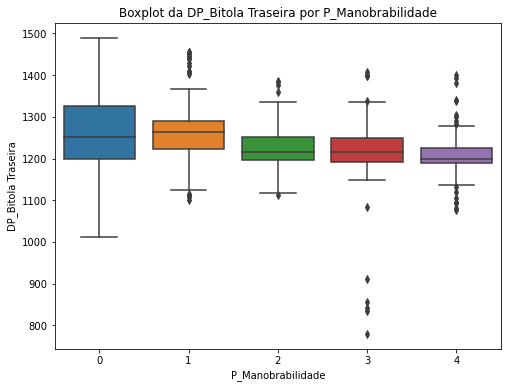

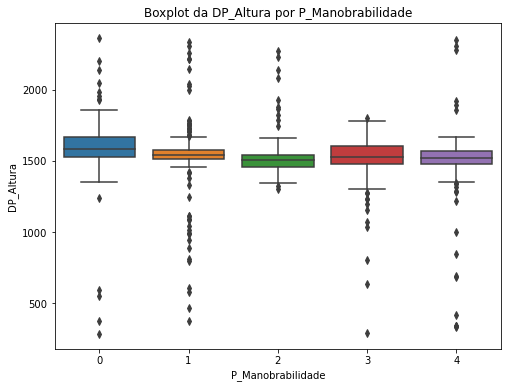

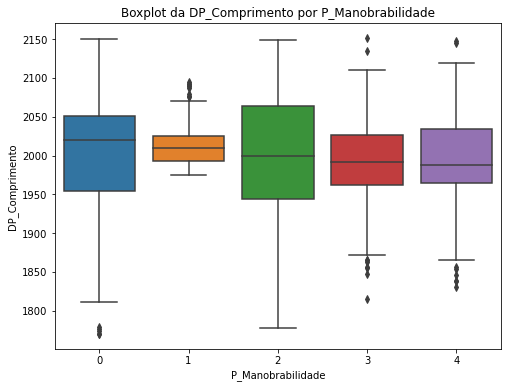

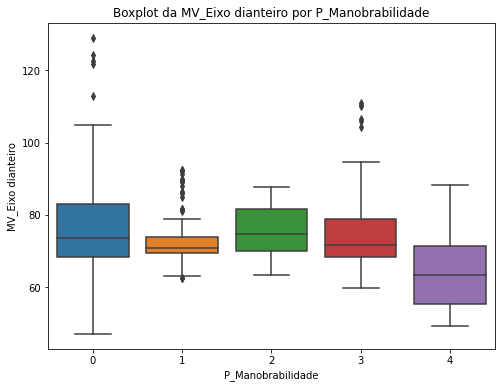

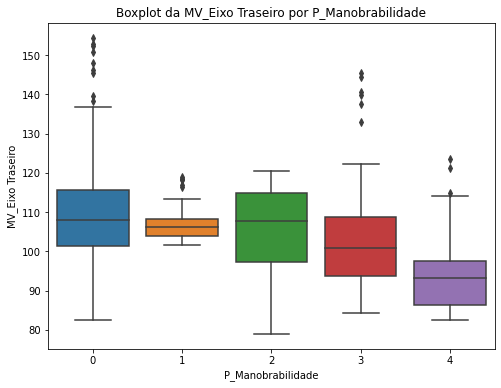

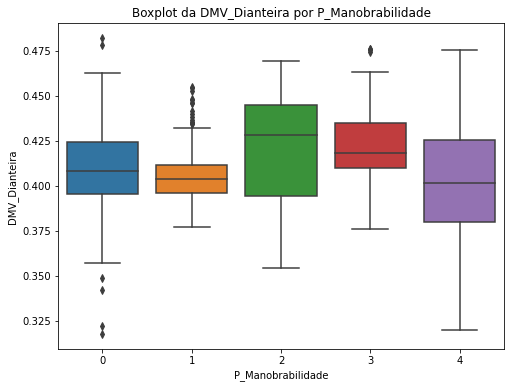

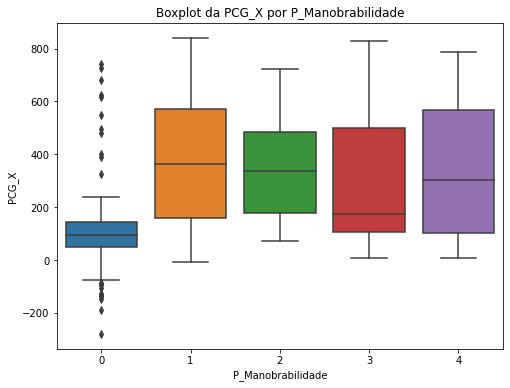

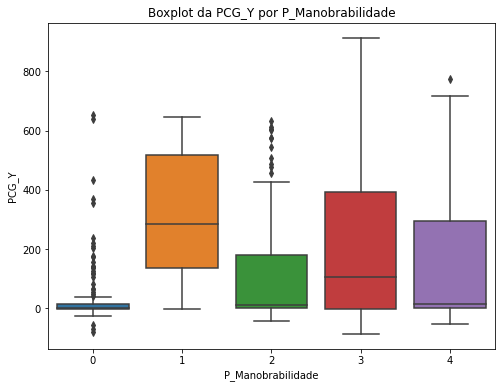

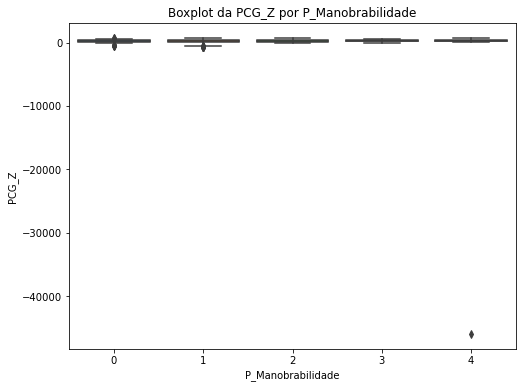

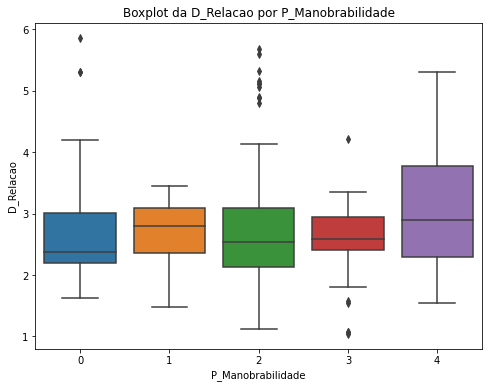

In [14]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Manobrabilidade':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Manobrabilidade', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Manobrabilidade')
        plt.ylabel(coluna)
        plt.xlabel('P_Manobrabilidade')
        plt.show()

In [15]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Manobrabilidade']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Manobrabilidade'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Manobrabilidade'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Manobrabilidade'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

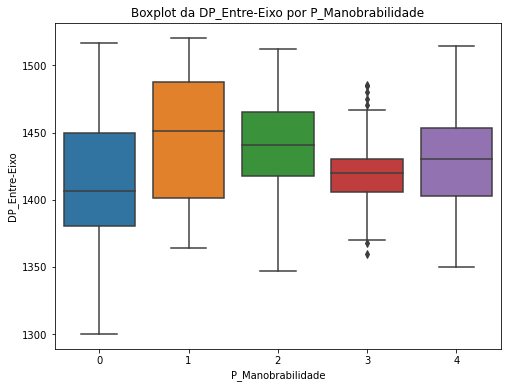

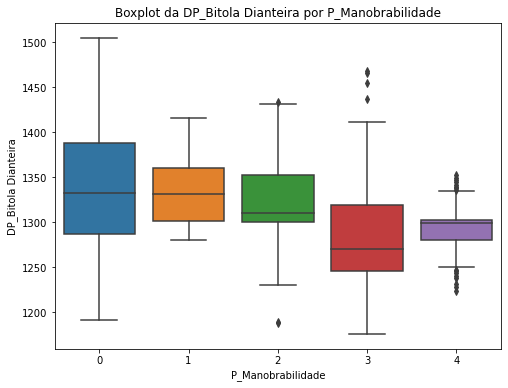

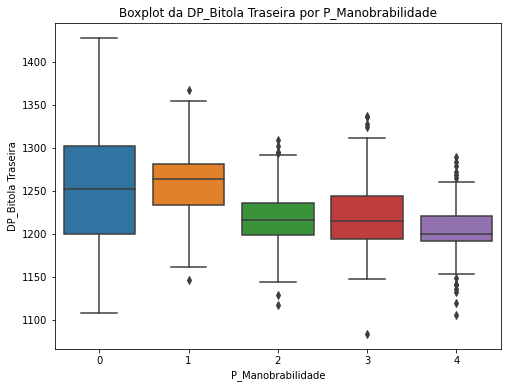

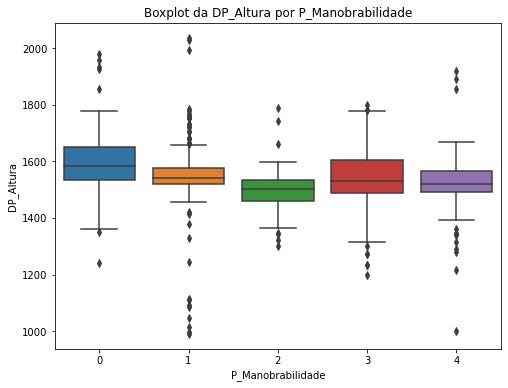

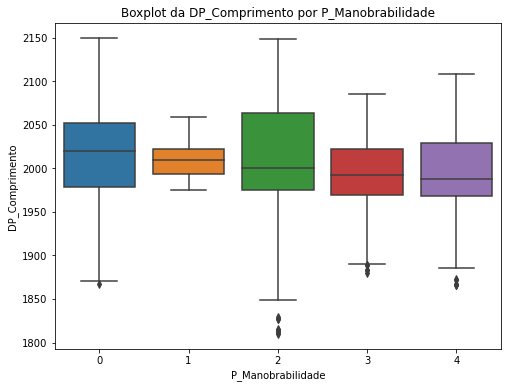

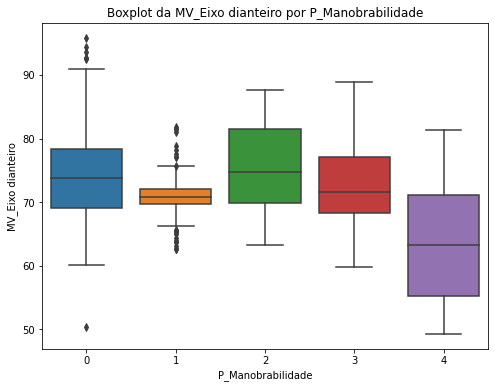

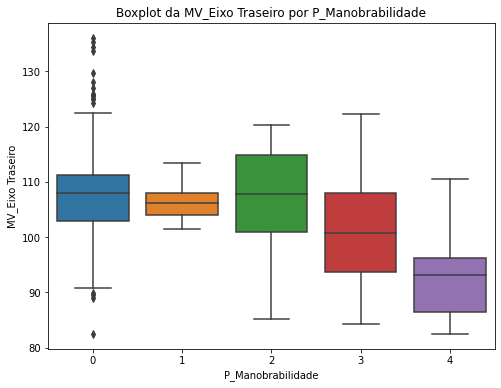

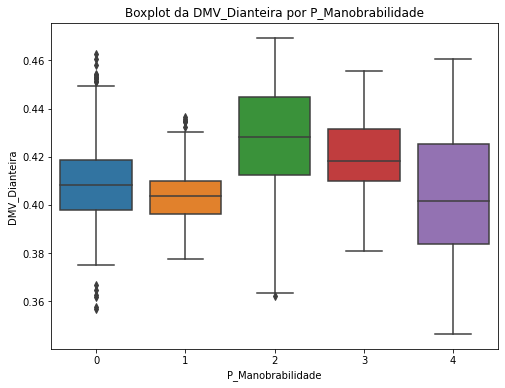

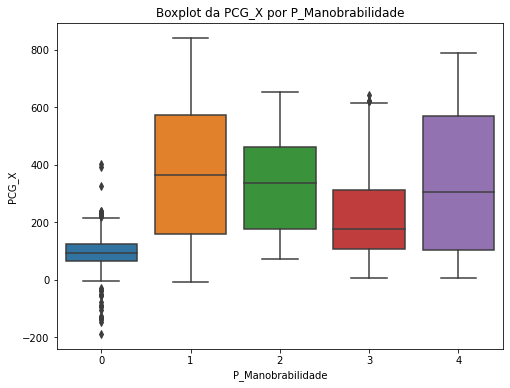

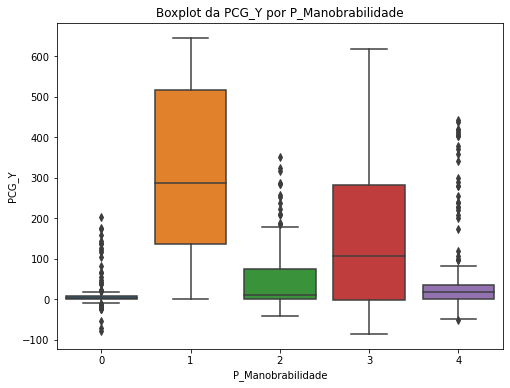

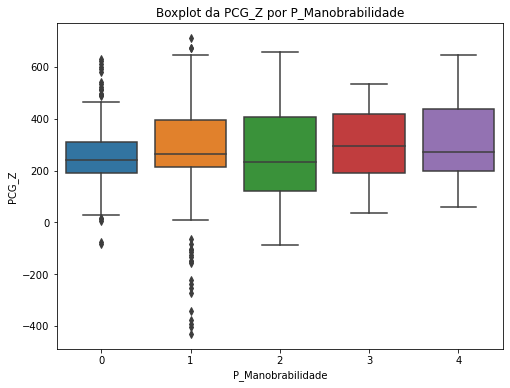

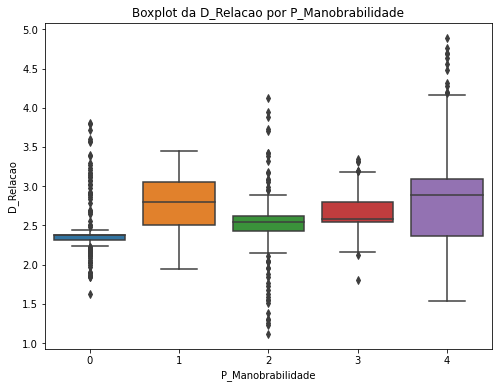

In [16]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Manobrabilidade':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Manobrabilidade', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Manobrabilidade')
        plt.ylabel(coluna)
        plt.xlabel('P_Manobrabilidade')
        plt.show()

In [17]:
df = df_tratado

In [18]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

NameError: name 'load_workbook' is not defined

## Análise de Variáveis

In [21]:
data_corr = df.drop(['P_Manobrabilidade'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

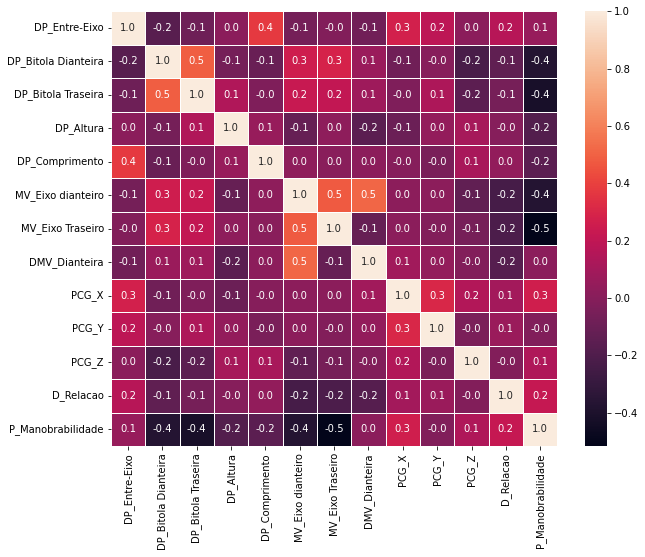

In [22]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [23]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 5

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

     DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0      1375.000000          1320.000000         1275.000000  1550.000000   
1      1437.352834          1301.084856         1257.383792  1526.436265   
2      1352.624255          1320.913741         1182.351714  1606.885444   
3      1307.150880          1332.524916         1282.562627  1611.635996   
4      1393.831096          1408.554269         1398.255323  1554.642728   
..             ...                  ...                 ...          ...   
993    1497.768383          1300.000000         1200.000000  1519.771583   
995    1458.353300          1291.303150         1196.160187  1391.839336   
996    1500.000000          1297.592843         1210.496743  1464.867874   
997    1514.746926          1261.565233         1191.948088  1533.951251   
998    1371.353579          1302.745066         1202.325865  1534.546076   

     DP_Comprimento      Massa  DMV_Dianteira       PCG_X      PCG_Y  \
0       2050.00

In [24]:
# Aplicar PCA para reduzir variáveis de alta correlação - Bitola
variaveis_reduzidas = df[['DP_Bitola Traseira', 'DP_Bitola Dianteira']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'DP_Bitola Traseira',
    'DP_Bitola Dianteira',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 1

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'DP_Bitola', variavel_reduzida)

print(df)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento      Massa  \
0      1375.000000   28.822318  1550.000000     2050.000000  -7.097317   
1      1437.352834    3.129721  1526.436265     2065.013452  -5.335327   
2      1352.624255  -25.787695  1606.885444     2077.082448  -0.117886   
3      1307.150880   43.384605  1611.635996     1982.262142   5.635338   
4      1393.831096  173.467305  1554.642728     1946.073774  26.198481   
..             ...         ...          ...             ...        ...   
993    1497.768383  -32.018135  1519.771583     1865.908746   4.849399   
995    1458.353300  -41.286571  1391.839336     1932.657829 -14.945250   
996    1500.000000  -27.678483  1464.867874     2018.288445  -6.067642   
997    1514.746926  -67.652025  1533.951251     2021.909241 -24.750931   
998    1371.353579  -28.427292  1534.546076     1977.514112  -6.299839   

     DMV_Dianteira       PCG_X      PCG_Y       PCG_Z  D_Relacao  \
0         0.417540   65.000000  -4.000000  

In [25]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_teste)

     DP_Entre-Eixo  DP_Bitola    DP_Altura  DP_Comprimento      Massa  \
640    1400.000000   2.566323  1499.368376     2071.555313   7.811702   
510    1440.886149  46.409288  1515.654566     1962.995976   4.708422   
307    1426.462073 -24.166620  1543.410148     2025.365747   5.677306   
741    1435.276876  -9.739282  1534.231850     2059.676888 -15.925636   
761    1422.620131 -13.451495  1539.760703     1955.976145 -19.084765   
..             ...        ...          ...             ...        ...   
333    1463.679047 -15.637210  1521.901501     1995.711741   4.878191   
351    1500.016367  32.718056  1557.268815     2021.663599  -1.644947   
613    1479.911500 -36.610395  1515.626969     2085.051892 -19.633898   
544    1447.781637  25.033914  1526.579551     2016.402021  10.871679   
901    1481.496601   7.808320  1456.792848     2070.077111  -6.491713   

     DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  D_Relacao  \
640       0.392486  138.429161  -86.519084  223.395098

# Escolha do Modelo

## Regressão Logística:

In [26]:
# Modelo de regressão logística.
model_LR = LogisticRegression()
model_LR.fit(X_treino, Y_treino)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [27]:
# Avaliação do desempenho do modelo.
Y_pred = model_LR.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão Logística:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão Logística:
Acurácia: 0.57
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.61      0.86      0.72        51
           1       0.67      0.58      0.62        50
           2       0.63      0.50      0.56        44
           3       0.38      0.33      0.35        42
           4       0.51      0.51      0.51        39

    accuracy                           0.57       226
   macro avg       0.56      0.56      0.55       226
weighted avg       0.57      0.57      0.56       226



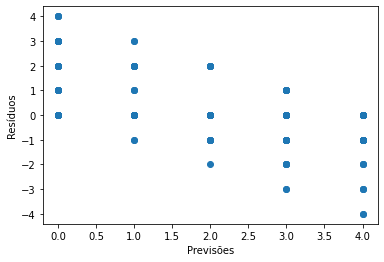

In [28]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Máquinas de Vetores de Suporte (SVM)

In [29]:
# Modelo SVM com um kernel linear e "um contra todos"
model_SVM = SVC(kernel='linear', decision_function_shape='ovr')
model_SVM.fit(X_treino, Y_treino)

SVC(kernel='linear')

In [30]:
# Avaliação do desempenho do modelo.
Y_pred = model_SVM.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Máquinas de Vetores de Suporte:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Máquinas de Vetores de Suporte:
Acurácia: 0.65
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      0.90      0.75        51
           1       0.82      0.54      0.65        50
           2       0.73      0.61      0.67        44
           3       0.42      0.40      0.41        42
           4       0.67      0.77      0.71        39

    accuracy                           0.65       226
   macro avg       0.66      0.65      0.64       226
weighted avg       0.66      0.65      0.64       226



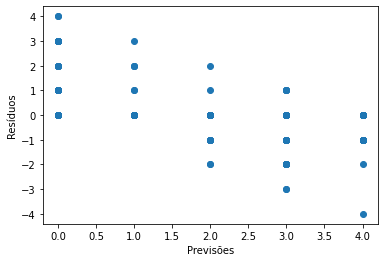

In [31]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## K-Nearest Neighbors

In [32]:
k = 3  # Número de vizinhos (Altere por necessidade)

# Modelo de K-Vizinhos Mais Próximos (K-Nearest Neighbors - KNN).
model_KNN = KNeighborsClassifier(n_neighbors=k)
model_KNN.fit(X_treino, Y_treino)

KNeighborsClassifier(n_neighbors=3)

In [33]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_KNN.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para K-Vizinhos Mais Próximos:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para K-Vizinhos Mais Próximos:
Acurácia: 0.67
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        51
           1       0.65      0.68      0.67        50
           2       0.68      0.57      0.62        44
           3       0.59      0.45      0.51        42
           4       0.65      0.72      0.68        39

    accuracy                           0.67       226
   macro avg       0.66      0.66      0.66       226
weighted avg       0.66      0.67      0.66       226



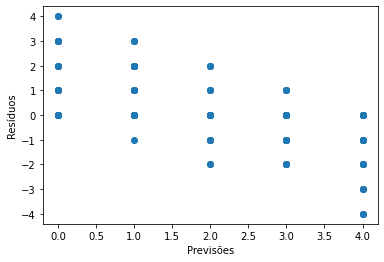

In [34]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Decision Tree Classifier

In [35]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

In [36]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_DTC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Árvore de Decisão de Classificação:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Árvore de Decisão de Classificação:
Acurácia: 0.69
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        51
           1       0.85      0.68      0.76        50
           2       0.75      0.75      0.75        44
           3       0.63      0.52      0.57        42
           4       0.59      0.69      0.64        39

    accuracy                           0.69       226
   macro avg       0.70      0.69      0.69       226
weighted avg       0.70      0.69      0.69       226



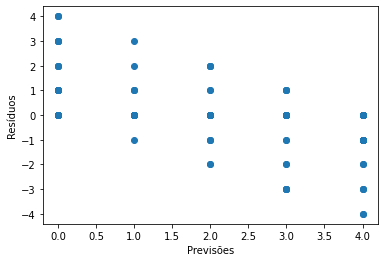

In [37]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## Random Forest Classifier

In [38]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

In [39]:
# Avaliação do desempenho do modelo.
Y_pred = model_RFC.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Regressão de Floresta Aleatória:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Regressão de Floresta Aleatória:
Acurácia: 0.88
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85        51
           1       0.96      0.92      0.94        50
           2       0.95      0.86      0.90        44
           3       0.97      0.69      0.81        42
           4       0.82      0.92      0.87        39

    accuracy                           0.88       226
   macro avg       0.89      0.87      0.87       226
weighted avg       0.89      0.88      0.88       226



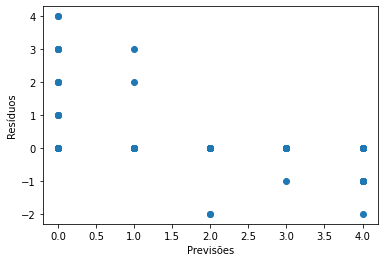

In [40]:
# Analisar os resíduos.
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

## XGBoost

In [41]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [42]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

Desempenho para Extreme Gradient Boosting:
Acurácia: 0.87
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        51
           1       0.92      0.88      0.90        50
           2       0.91      0.91      0.91        44
           3       0.91      0.71      0.80        42
           4       0.82      0.92      0.87        39

    accuracy                           0.87       226
   macro avg       0.88      0.87      0.87       226
weighted avg       0.88      0.87      0.87       226



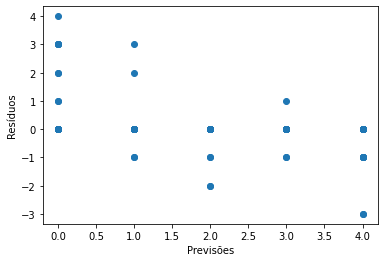

In [43]:
# Analisar os resíduos
residuos = Y_teste - Y_pred

# Plote um gráfico de dispersão dos resíduos em relação às previsões
plt.scatter(Y_pred, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

# Treinamento do Modelo

## Bootstraps

In [44]:
n_iterations = 100  # Número de iterações do Bootstrap

# Lista para armazenar as métricas de desempenho em cada iteração
performance_metrics = []

for _ in range(n_iterations):
    # Amostragem Bootstrap: crie um conjunto de treinamento com reamostragem
    indices_amostra = np.random.choice(len(X_treino), size=len(X_treino), replace=True)
    X_bootstrap = X_treino.iloc[indices_amostra]  
    y_bootstrap = Y_treino.iloc[indices_amostra]

    # Crie e treine seu modelo
    model_XGB.fit(X_bootstrap, y_bootstrap)

    # Avalie o modelo no conjunto de teste
    desempenho = model_XGB.score(X_teste, Y_teste)  # Mede a acurácia
    performance_metrics.append(desempenho)

In [45]:
# Calcule as métricas resumidas (por exemplo, média e desvio padrão)
media_desempenho = np.mean(performance_metrics)
desvio_padrao_desempenho = np.std(performance_metrics)

# Imprima as métricas resumidas
print(f'Média do desempenho: {media_desempenho:.4f}')
print(f'Desvio Padrão do desempenho: {desvio_padrao_desempenho:.4f}')

Média do desempenho: 0.8194
Desvio Padrão do desempenho: 0.0190


# Avaliação do Modelo

## Cross-Validation

In [46]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [47]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 87.64%
Intervalo de acurácia: [83.32% ~ 91.97%]


In [48]:
# Calcule a média das pontuações para avaliação de Precisão do modelo
def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean * 100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='precision_macro') # Checar Modelo
intervalo_prec(scores)

Precisão média: 88.26%
Intervalo de Precisão: [83.45% ~ 93.08%]


In [49]:
# Calcule a média das pontuações para avaliação de Recall do modelo
def intervalo_recall(results):
    mean = results.mean()
    dv = results.std()
    print('Recall médio: {:.2f}%'.format(mean * 100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='recall_macro') # Checar Modelo
intervalo_recall(scores)

Recall médio: 87.13%
Intervalo de Recall: [82.08% ~ 92.17%]


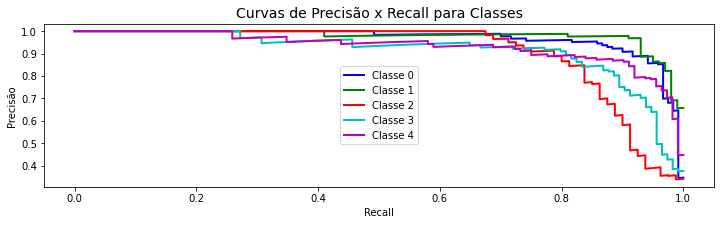

In [50]:
# Comparar scores de Previsão e Recall
# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

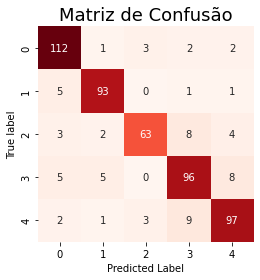

In [51]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [52]:
# Relatório do modelo
print('Relatório de classificação:\n', classification_report(Y_treino, Y_pred, digits=4))

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.8819    0.9333    0.9069       120
           1     0.9118    0.9300    0.9208       100
           2     0.9130    0.7875    0.8456        80
           3     0.8276    0.8421    0.8348       114
           4     0.8661    0.8661    0.8661       112

    accuracy                         0.8764       526
   macro avg     0.8801    0.8718    0.8748       526
weighted avg     0.8772    0.8764    0.8759       526



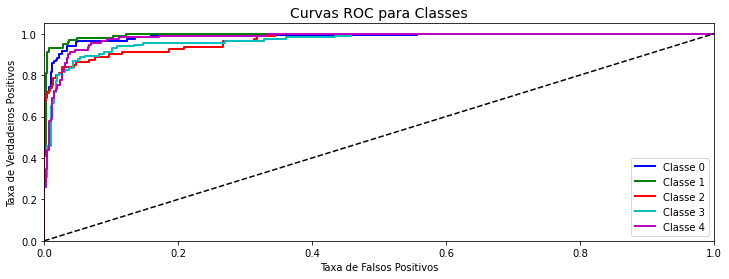

In [53]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para Classes', fontsize=14)
plt.show()

In [54]:
# Área sob a Curva
print('Área sob a curva ROC: {:.4f}'.format(roc_auc_score(Y_treino, y_scores, multi_class='ovr', average='macro')))

Área sob a curva ROC: 0.9797


In [55]:
# Treinamento do modelo 
# model_XGB.fit(X_treino, Y_treino) # Checar modelo

# Fazer previsões no conjunto de teste
Y_pred_teste = model_XGB.predict(X_teste)

# Acurácia no conjunto de teste
accuracy = accuracy_score(Y_teste, Y_pred_teste)
print('Acurácia no conjunto de teste: {:.2f}%'.format(accuracy * 100))

# Precisão no conjunto de teste
precision = precision_score(Y_teste, Y_pred_teste, average='macro')
print('Precisão no conjunto de teste: {:.2f}%'.format(precision * 100))

# Recall no conjunto de teste
recall = recall_score(Y_teste, Y_pred_teste, average='macro')
print('Recall no conjunto de teste: {:.2f}%'.format(recall * 100))

# Relatório de classificação no conjunto de teste
print('Relatório de classificação no conjunto de teste:\n', classification_report(Y_teste, Y_pred_teste, digits=4))

Acurácia no conjunto de teste: 81.86%
Precisão no conjunto de teste: 82.47%
Recall no conjunto de teste: 81.63%
Relatório de classificação no conjunto de teste:
               precision    recall  f1-score   support

           0     0.7667    0.9020    0.8288        51
           1     0.9750    0.7800    0.8667        50
           2     0.8043    0.8409    0.8222        44
           3     0.8158    0.7381    0.7750        42
           4     0.7619    0.8205    0.7901        39

    accuracy                         0.8186       226
   macro avg     0.8247    0.8163    0.8166       226
weighted avg     0.8284    0.8186    0.8192       226



## Análise de Variáveis 

In [56]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.08137854 0.10289568 0.07131144 0.10615388 0.15544018 0.11216909
 0.11990912 0.11587344 0.03566158 0.09920697]


<Figure size 1440x1152 with 0 Axes>

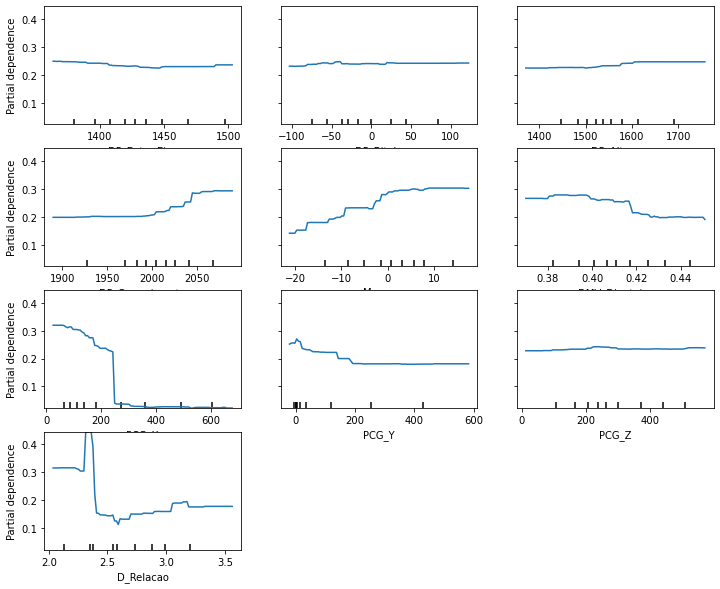

In [57]:
# Analisar como uma variável afeta as previsões
colunas = df.columns[:-1].tolist() # Separar as variáveis

plt.figure(figsize=(20, 16))

# Crie PDPs para as variáveis escolhidas
plot_partial_dependence(model_XGB, X_treino, features=colunas, target=Y_treino.all(), grid_resolution=100)

# Obter a figura atual e definir o tamanho
fig = plt.gcf()
fig.set_size_inches(12, 10)

plt.show()

[20:02:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[20:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 96%|=================== | 1090/1130 [00:16<00:00]       

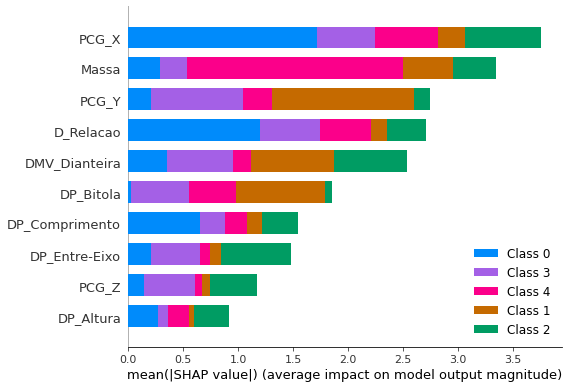

In [58]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Aprimoramento de Parâmetros

## Tuning

In [ ]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'max_depth': [3, 4, 5],         # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],   # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],   # Fração de amostras usadas para treinamento de cada árvore
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fração de colunas usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],  # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],         # Regularização gamma (parâmetro de penalização)
    'reg_alpha': [0, 0.1, 0.2],     # Regularização L1 (parâmetro de penalização)
    'reg_lambda': [1, 1.1, 1.2]     # Regularização L2 (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [ ]:
# Guardar os parâmetros encontrados fora do código
melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
joblib.dump(melhores_parametros, 'melhores_parametros_man.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_man.pkl')

In [ ]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params)

In [ ]:
# Avaliação do desempenho do modelo 
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

## Redução de Dimensão

In [ ]:
# Selecione um número específico de características mais importantes
num_caracteristicas_selecionadas = 3  # Por exemplo, selecione as 3 mais importantes

X_treino_selecionado = X_treino[:, indices_ordenados[:num_caracteristicas_selecionadas]]
X_teste_selecionado = X_teste[:, indices_ordenados[:num_caracteristicas_selecionadas]]

# Em seguida, treine seu modelo no conjunto de dados com características selecionadas
model_XGB.fit(X_treino_selecionado, Y_treino)

In [ ]:
# Avaliação do desempenho do modelo usando as métricas de erro quadrático médio (RMSE) e o coeficiente de determinação (R2).
Y_pred = model_XGB.predict(X_teste)

acuracia = accuracy_score(Y_teste, Y_pred)
relatorio_classificacao = classification_report(Y_teste, Y_pred)
    
print(f"Desempenho para Extreme Gradient Boosting:")
print(f'Acurácia: {acuracia:.2f}')
print('Relatório de Classificação:')
print(relatorio_classificacao)

# Predição

In [ ]:
# Valor único para fazer a previsão
X_prev = np.array([6]).reshape(-1, 1) # Colocar os valores pedidos

# Faça a previsão
previsao = modelo_carregado.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')